In [2]:
!pip install pennylane

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
from collections import Counter
import heapq
from collections import defaultdict

In [4]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance in miles"""
    from math import radians, sin, cos, sqrt, atan2
    R = 3959  # Earth radius in miles
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c


In [5]:


def generate_network():
    hubs = {
        'JFK': (40.64, -73.78),  
        'BOS': (42.36, -71.01),  
        'ATL': (33.64, -84.43),  
        'MIA': (25.79, -80.29)   
    }
    hub_names = list(hubs.keys())
    flights = []
    
    base_time = datetime(2025,12,3,8,0)
    for i, orig in enumerate(hub_names):
        for j, dest in enumerate(hub_names):
            if orig == dest: continue
            
            # Distance → duration
            dist = abs(i-j)*300 + np.random.uniform(50,150)  # ~600-1200 miles
            duration = dist/500 + 0.5
            
            # 2 flights per route (morning + afternoon)
            for offset in [0, 6]:  # 6h spacing
                dep = base_time + timedelta(hours=offset)
                arr = dep + timedelta(hours=duration)
                cost = dist*0.8 + duration*50
                
                flights.append({
                    'flight_id': len(flights),
                    'origin': orig,
                    'destination': dest,
                    'departure_time': dep,
                    'arrival_time': arr,
                    'duration_hours': duration,
                    'cost': cost,
                    'handling_time': 1.5
                })
    
    df = pd.DataFrame(flights)
    print(f"Generated {len(df)} flights across 4 hubs.")
    return df
flights_16qubit = generate_network()
scenario_16qubit = {'origin': 'JFK', 'destination': 'MIA', 'max_time': 12.0}
print(f"Scenario: {scenario_16qubit['origin']} -> {scenario_16qubit['destination']} ({scenario_16qubit['max_time']}h)")
flights_16qubit = flights_16qubit.head(16).copy()


Generated 24 flights across 4 hubs.
Scenario: JFK -> MIA (12.0h)


In [6]:
scenario = {'origin': 'JFK', 'destination': 'MIA', 'max_time': 12.0}
print(f"Scenario: {scenario['origin']} -> {scenario['destination']} ({scenario['max_time']}h)")

Scenario: JFK -> MIA (12.0h)


In [7]:
remove = (flights_16qubit['origin']=='JFK') & (flights_16qubit['destination']=='MIA')
flights_16qubit = flights_16qubit[~remove].copy()

In [8]:
flights_16qubit.iloc[[0,9]]

,flight_id,origin,destination,departure_time,arrival_time,duration_hours,cost,handling_time
0,0,JFK,BOS,2025-12-03 08:00:00,2025-12-03 09:12:18.978907,1.205272,342.372363,1.5
11,11,BOS,MIA,2025-12-03 14:00:00,2025-12-03 15:55:36.959972,1.926933,667.119996,1.5


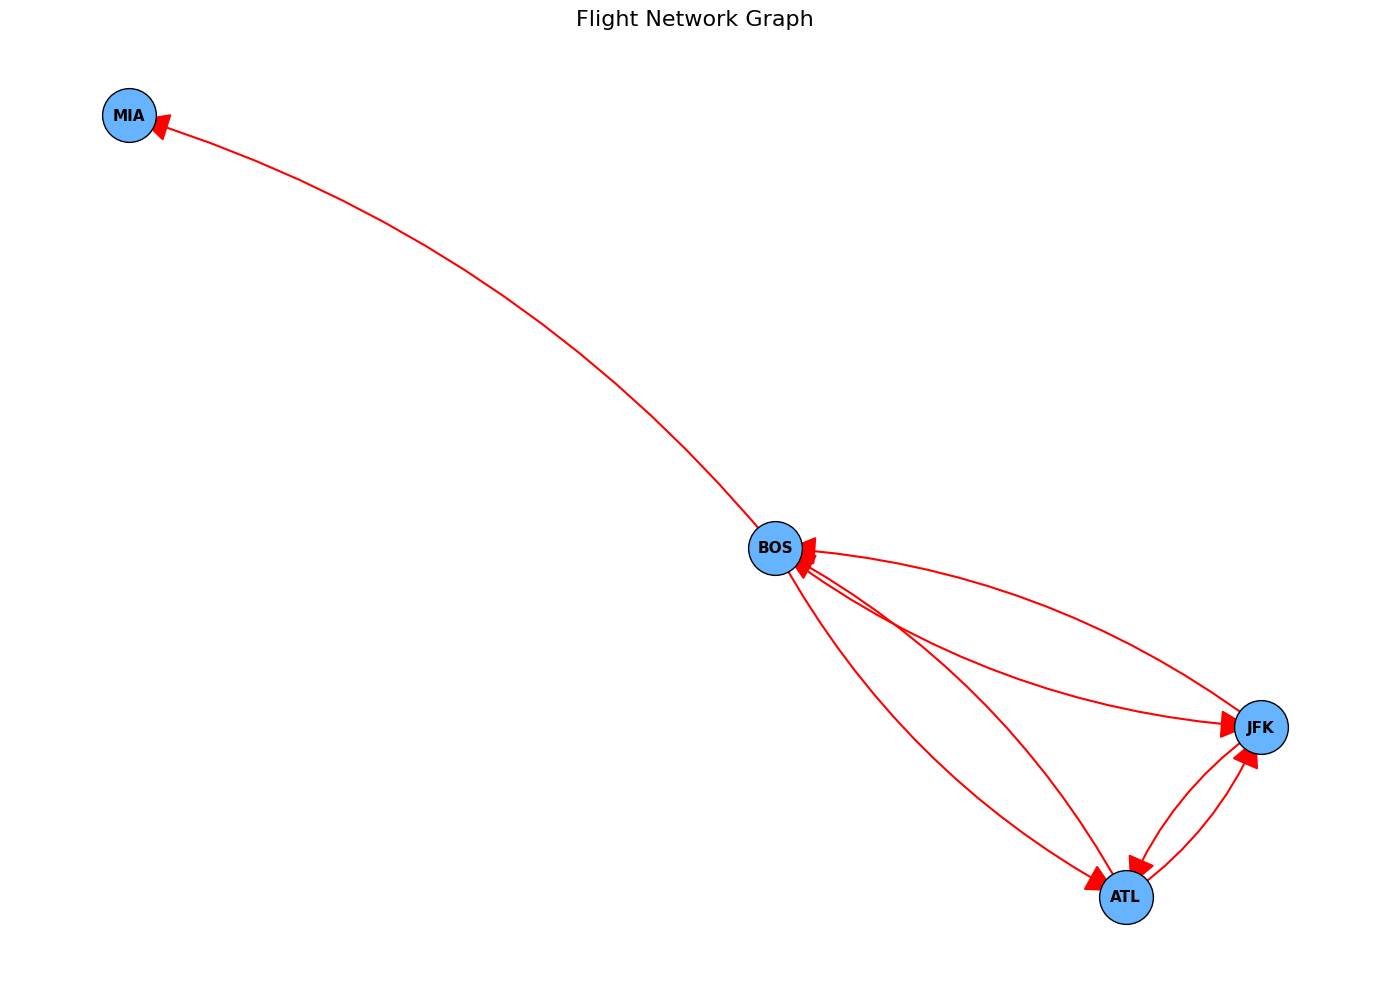

Network contains 4 nodes and 7 edges.


In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add nodes (airports)
airports = set(flights_16qubit['origin'].unique()) | set(flights_16qubit['destination'].unique())
G.add_nodes_from(airports)

# Add edges (flights)
for _, flight in flights_16qubit.iterrows():
    G.add_edge(
        flight['origin'], 
        flight['destination'],
        weight=flight['cost']
    )

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=2)  # 'k' increases spacing between nodes

# 1. Draw Nodes
nx.draw_networkx_nodes(G, pos, node_color='#66b3ff', node_size=1500, edgecolors='black')

# 2. Draw Labels
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', font_family='sans-serif')

# 3. Draw Edges with visible arrows and curved lines
nx.draw_networkx_edges(
    G, 
    pos, 
    edge_color='red', 
    arrows=True, 
    arrowstyle='-|>',  # A sharper, cleaner arrow style
    arrowsize=45,      # Significantly larger arrows
    width=1.5,         # Thicker lines
    connectionstyle="arc3,rad=0.15" # Curves edges so bidirectional flights don't overlap
)

plt.title("Flight Network Graph", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Network contains {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

In [11]:
class MiniLabel:
    def __init__(self, node, time, cost, path):
        self.node, self.time, self.cost, self.path = node, time, cost, path[:]
    def __lt__(self, o): return self.cost < o.cost
    def dominates(self, o): 
        return self.node == o.node and self.time <= o.time and self.cost <= o.cost and (self.time < o.time or self.cost < o.cost)

def classical_16qubit(flights_df, origin, dest, max_time):
    graph = defaultdict(list)
    for _, f in flights_df.iterrows(): graph[f.origin].append(f)
    
    pq, labels = [], defaultdict(list)
    init = MiniLabel(origin, 0, 0, [origin])
    heapq.heappush(pq, init); labels[origin].append(init)
    
    best = None; explored = 0
    while pq:
        curr = heapq.heappop(pq); explored += 1
        labels[curr.node] = [l for l in labels[curr.node] if not curr.dominates(l) and l != curr]
        labels[curr.node].append(curr)
        
        if curr.node == dest:
            if best is None or curr.cost < best.cost: best = curr
            continue
        
        for f in graph[curr.node]:
            new_time = curr.time + f.duration_hours + 1.5
            if new_time > max_time: continue
            new_label = MiniLabel(f.destination, new_time, curr.cost + f.cost, curr.path + [f.destination])
            if not any(l.dominates(new_label) for l in labels[f.destination]):
                heapq.heappush(pq, new_label)
    
    path_str = ' -> '.join(best.path) if best else 'No solution'
    cost_str = f"${best.cost:.1f}" if best else 'N/A'
    print(f"Classical solution: {path_str} (Cost: {cost_str})")
    return best


classical_optimal = classical_16qubit(flights_16qubit, scenario_16qubit['origin'], scenario_16qubit['destination'], scenario_16qubit['max_time'])
classical_cost = classical_optimal.cost if classical_optimal else float('inf')

Classical solution: JFK -> BOS -> MIA (Cost: $1009.5)


In [12]:
import numpy as np

def build_qubo(flights_df, origin, dest, max_time):
    n = len(flights_df)
    Q = np.zeros((n, n))

    A_mandatory = 25.0 
    B_flow      = 12.0 
    C_temporal  = 30.0  
    D_cost      = 1.0   
    
    print(f"Building QUBO matrix (N={n} flights)...")

    # 1. Cost Minimization (Diagonal)
    if flights_df['cost'].max() > 0:
        norm_costs = flights_df['cost'] / flights_df['cost'].max()
    else:
        norm_costs = flights_df['cost']
        
    for i in range(n):
        Q[i, i] += D_cost * norm_costs.iloc[i]

    # 2. Origin Constraint (Exactly 1 flight departing Origin)
    # Math: (Sum x - 1)^2  ->  Sum(x_i^2) + 2*Sum(x_i*x_j) - 2*Sum(x_i)
    # Since x^2 = x, Diagonal gets: +1 - 2 = -1
    outs = [i for i, f in enumerate(flights_df.itertuples()) if f.origin == origin]
    
    if not outs:
        print(f"No flights found departing '{origin}'!")
        
    for i in outs:
        Q[i, i] -= A_mandatory  # The Linear Reward (-A)
    for i in range(len(outs)):
        for j in range(i + 1, len(outs)):
            u, v = outs[i], outs[j]
            Q[u, v] += 2 * A_mandatory  # The Quadratic Penalty (+2A)

    # 3. Destination Constraint (Exactly 1 flight arriving Destination)
    ins = [i for i, f in enumerate(flights_df.itertuples()) if f.destination == dest]
    
    if not ins:
        print(f"No flights found arriving '{dest}'! Check spelling.")
        
    for i in ins:
        Q[i, i] -= A_mandatory
    for i in range(len(ins)):
        for j in range(i + 1, len(ins)):
            u, v = ins[i], ins[j]
            Q[u, v] += 2 * A_mandatory

    # 4. Flow Conservation (Intermediate Nodes)
    # Math: (In - Out)^2  ->  In^2 + Out^2 - 2*In*Out
    all_airports = set(flights_df['origin']) | set(flights_df['destination'])
    intermediate_hubs = all_airports - {origin, dest}
    
    for hub in intermediate_hubs:
        in_indices = [i for i, f in enumerate(flights_df.itertuples()) if f.destination == hub]
        out_indices = [i for i, f in enumerate(flights_df.itertuples()) if f.origin == hub]
        
        if not in_indices and not out_indices: continue

        # Term 1: +In^2 (Penalize multiple arrivals)
        for i in in_indices: Q[i, i] += B_flow
        for i in range(len(in_indices)):
            for j in range(i + 1, len(in_indices)):
                u, v = in_indices[i], in_indices[j]
                Q[u, v] += 2 * B_flow

        # Term 2: +Out^2 (Penalize multiple departures)
        for i in out_indices: Q[i, i] += B_flow
        for i in range(len(out_indices)):
            for j in range(i + 1, len(out_indices)):
                u, v = out_indices[i], out_indices[j]
                Q[u, v] += 2 * B_flow

        # Term 3: -2*In*Out (Reward for Connection)
        # We want -2*B total. Since we only write to Q[u,v] (upper), we just write -2*B once.
        for i in in_indices:
            for j in out_indices:
                # Ensure we write to Upper Triangular (row < col)
                u, v = min(i, j), max(i, j)
                if u == v: continue # Should not happen in DAG, but safety first
                Q[u, v] -= 2 * B_flow

    # 5. Temporal Constraints

    for i in range(n):
        fi = flights_df.iloc[i]
        for j in range(i + 1, n): # Loop j > i only
            fj = flights_df.iloc[j]
            
            
            # Case A: i -> j
            if fi.destination == fj.origin:
                gap = (fj.departure_time - fi.arrival_time).total_seconds() / 3600
                if gap < 1.5:
                    Q[i, j] += C_temporal
                    
            # Case B: j -> i
            elif fj.destination == fi.origin:
                gap = (fi.departure_time - fj.arrival_time).total_seconds() / 3600
                if gap < 1.5:
                    Q[i, j] += C_temporal

    # Normalize the entire matrix to range [-1, 1] for QAOA stability
    max_val = np.max(np.abs(Q))
    if max_val > 0:
        Q = Q / max_val
        print(f"QUBO matrix normalized by factor: {max_val:.1f}")
        
    return Q

In [13]:

qubo = build_qubo(flights_16qubit, 
                                      scenario_16qubit['origin'], 
                                      scenario_16qubit['destination'], 
                                      scenario_16qubit['max_time'])


Building QUBO matrix (N=14 flights)...
QUBO matrix normalized by factor: 74.0


In [14]:
max_val = np.max(np.abs(qubo))
qubo = qubo / max_val 

print(f"QUBO scaling: Original maximum = {max_val}, Scaled maximum = {np.max(np.abs(qubo))}")

QUBO scaling: Original maximum = 1.0, Scaled maximum = 1.0


In [15]:
# # Test your QUBO energy for key cases
# qubo_test = qubo

# def qubo_energy(x, Q):
#     """Compute QUBO energy for bit vector x"""
#     return x @ Q @ x

# # Test cases
# all_zero = np.zeros(14)
# one_origin = np.zeros(14); one_origin[0] = 1  # Single origin flight
# two_flights = np.zeros(14); two_flights[[0,9]] = 1  # Origin + connection
# all_ones = np.ones(14)  # BAD solution

# print("🔍 QUBO Energy Test:")
# print(f"All zero:     {qubo_energy(all_zero, qubo_test):.1f}")
# print(f"One flight:   {qubo_energy(one_origin, qubo_test):.1f}")
# print(f"Two flights:  {qubo_energy(two_flights, qubo_test):.1f}")
# print(f"ALL ONES:     {qubo_energy(all_ones, qubo_test):.1f}  ← SHOULD BE HIGH!")
# print(f"ALL ONES:     {qubo_energy(sol, qubo_test):.1f}  ← SHOULD BE HIGH!")



In [16]:
import numpy as np1
import itertools

def qubo_energy(x, Q):
    """Compute QUBO energy for bit vector x"""
    return x @ Q @ x


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def qubo_to_ising(Q):

    """
    Converts a QUBO matrix Q into Ising Hamiltonian parameters J and h.
    Mapping: x_i = (1 - s_i) / 2
    """
    n = Q.shape[0]
    h = np.zeros(n)      # Linear biases (external field)
    J = np.zeros((n, n)) # Quadratic couplings (interactions)
    offset = 0           # Constant energy offset (irrelevant for optimization but good for physics)

    for i in range(n):
        # Handle Diagonal Terms (Linear in QUBO)
        # Q_ii * x_i  =>  Q_ii * (0.5 - 0.5 * s_i)
        offset += 0.5 * Q[i, i]
        h[i] += -0.5 * Q[i, i]
        
        for j in range(n):
            if i == j: continue
            
            # Handle Off-Diagonal Terms (Quadratic in QUBO)
            # Q_ij * x_i * x_j => Q_ij * (1-s_i)/2 * (1-s_j)/2
            # Expand: 0.25*Q_ij - 0.25*Q_ij*s_i - 0.25*Q_ij*s_j + 0.25*Q_ij*s_i*s_j
            val = Q[i, j]
            if val != 0:
                offset += 0.25 * val
                h[i] += -0.25 * val # Influence on s_i
                h[j] += -0.25 * val # Influence on s_j (redundant if loop covers j,i, but safe here)
                J[i, j] += 0.25 * val

    return J, h, offset

# --- 3. Visualization Function ---
def plot_qubo_and_ising(Q, J, h):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Setup common plotting kwargs
    heatmap_args = {'cmap': 'RdBu', 'center': 0, 'annot': True, 'fmt': '.0f'}
    
    # 1. Plot QUBO
    sns.heatmap(Q, ax=axes[0], **heatmap_args)
    axes[0].set_title('QUBO Matrix (Binary $x \in \{0,1\}$)', fontsize=14)
    axes[0].set_xlabel('Variable $x_j$')
    axes[0].set_ylabel('Variable $x_i$')
    
    # 2. Plot Ising Couplings (J)
    # J is usually smaller, so use fmt='.1f'
    heatmap_args['fmt'] = '.1f' 
    sns.heatmap(J, ax=axes[1], **heatmap_args)
    axes[1].set_title('Ising Couplings $J_{ij}$ (Spin $s \in \{-1, +1\}$)', fontsize=14)
    axes[1].set_xlabel('Spin $s_j$')
    axes[1].set_ylabel('Spin $s_i$')

    # 3. Plot Ising Biases (h)
    # Reshape h for heatmap (n x 1)
    sns.heatmap(h.reshape(-1, 1), ax=axes[2], cmap='RdBu', center=0, annot=True, fmt='.1f', cbar=True)
    axes[2].set_title('Ising Biases $h_i$ (Magnetic Field)', fontsize=14)
    axes[2].set_xticks([]) # Hide x-ticks for vector
    axes[2].set_ylabel('Spin $s_i$')

    plt.tight_layout()
    plt.show()

<>:46: SyntaxWarning: invalid escape sequence '\i'
<>:54: SyntaxWarning: invalid escape sequence '\i'
<>:46: SyntaxWarning: invalid escape sequence '\i'
<>:54: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-1318407717.py:46: SyntaxWarning: invalid escape sequence '\i'
  axes[0].set_title('QUBO Matrix (Binary $x \in \{0,1\}$)', fontsize=14)
/tmp/ipython-input-1318407717.py:54: SyntaxWarning: invalid escape sequence '\i'
  axes[1].set_title('Ising Couplings $J_{ij}$ (Spin $s \in \{-1, +1\}$)', fontsize=14)


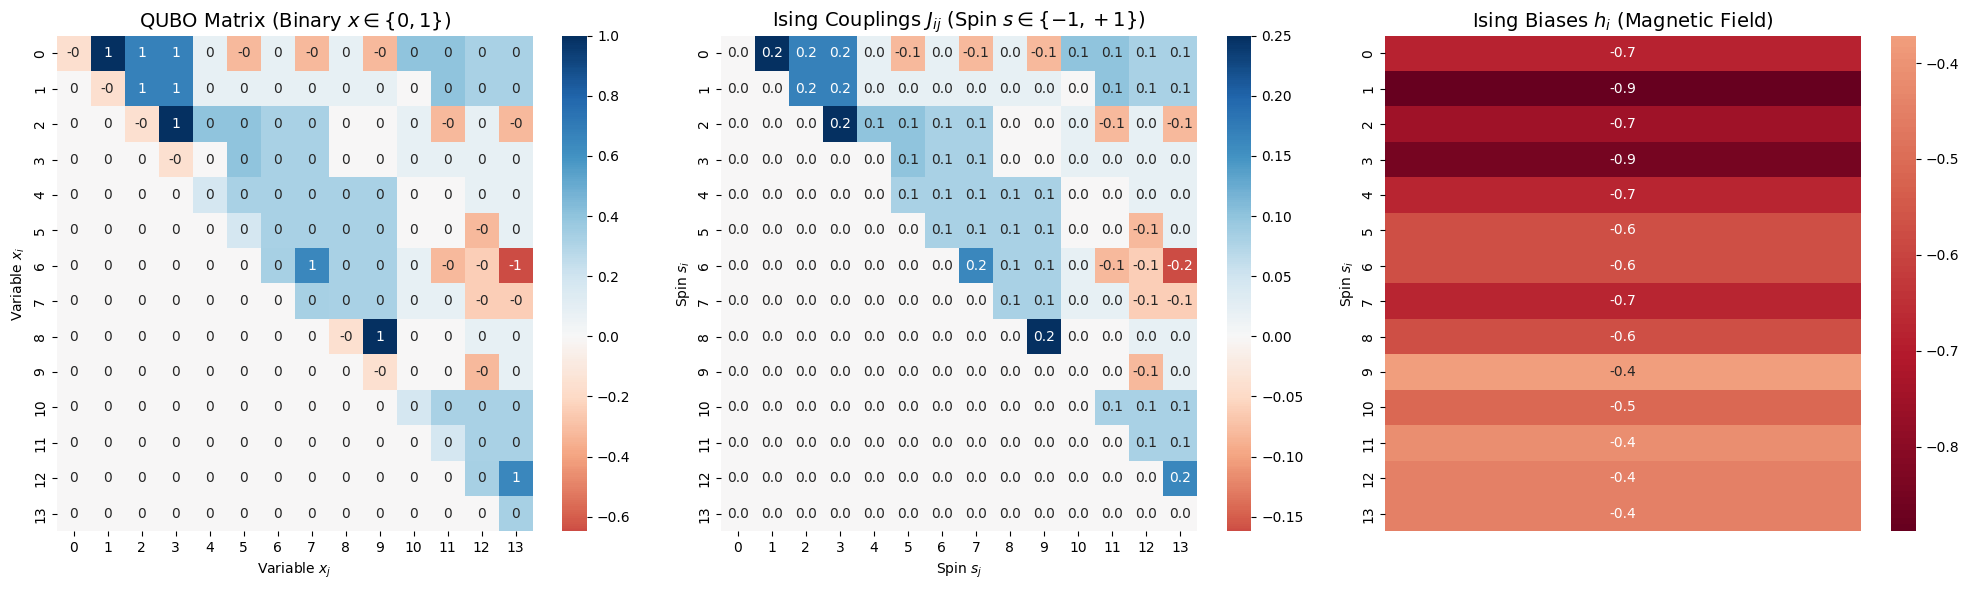

In [18]:
J_matrix, h_vector, offset = qubo_to_ising(qubo)
plot_qubo_and_ising(qubo, J_matrix, h_vector)

In [19]:
import pennylane as qml
from pennylane import numpy as np
def qubo_to_ham(Q):
    n_qubits = Q.shape[0]
    coeffs, ops = [], []
    
    # We assume Q is symmetric. If not, this logic requires symmetrization.
    # H = Sum(h_i Z_i) + Sum(J_ij Z_i Z_j)
    
    for i in range(n_qubits):
        # Calculate h_i
        # Contribution from diagonal: Q_ii * (1-Z_i)/2  -> coeff is -Q_ii/2
        # Contribution from off-diag: Q_ij * (1-Z_i)/2 * (1-Z_j)/2 
        # -> -Q_ij/4 * Z_i  (summed over j)
        
        h_term = -0.5 * Q[i, i]
        for j in range(n_qubits):
            if i != j:
                h_term -= 0.25 * (Q[i, j] + Q[j, i]) # Add both triangles
        
        if abs(h_term) > 1e-8:
            coeffs.append(h_term)
            ops.append(qml.PauliZ(i))
            
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            # Calculate J_ij
            # Contribution from off-diag: Q_ij/4 * Z_i * Z_j
            
            J_term = 0.25 * (Q[i, j] + Q[j, i])
            
            if abs(J_term) > 1e-8:
                coeffs.append(J_term)
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
                
    return qml.Hamiltonian(coeffs, ops)

In [20]:
hamiltonian = qubo_to_ham(qubo)

n_qubits = len(flights_16qubit) 
print(f"Quantum device configured with {n_qubits} qubits.")

dev = qml.device('default.qubit', wires=n_qubits)

def qaoa_circuit(params):
    for i in range(n_qubits): 
        qml.Hadamard(wires=i)
        
    for l in range(2):
        qml.ApproxTimeEvolution(hamiltonian, params[2*l], n=1)
        for i in range(n_qubits): 
            qml.RX(2*params[2*l+1], wires=i)

@qml.qnode(dev)
def cost_fn(params): 
    qaoa_circuit(params)
    return qml.expval(hamiltonian)

opt = qml.AdamOptimizer(stepsize=0.1)
params = np.array([0.1, 0.1, 0.1, 0.1], requires_grad=True)

print("Starting QAOA optimization...")
for i in range(60):
    params, cost = opt.step_and_cost(cost_fn, params)
    if i % 10 == 0:
        print(f"Optimization step {i}: Cost = {cost:.4f}")

@qml.qnode(dev, shots=2048)
def sample_fn(params):
    qaoa_circuit(params)
    return qml.sample()

samples = sample_fn(params)


Quantum device configured with 14 qubits.
Starting QAOA optimization...
Optimization step 0: Cost = 0.8053
Optimization step 10: Cost = 0.0111
Optimization step 20: Cost = -3.9101
Optimization step 30: Cost = -3.7720
Optimization step 40: Cost = -4.2624
Optimization step 50: Cost = -4.3624


In [21]:
import collections

bitstrings = ["".join(map(str, s)) for s in samples]
counts = collections.Counter(bitstrings)

print(f"Total unique bitstrings sampled: {len(counts.keys())}")

print("\nTop 10 candidate solutions by frequency:")
print("-" * 50)
min_energy = float('inf')
for bitstring, freq in counts.most_common(10):
    x = np.array([int(b) for b in bitstring])
    energy = x.T @ qubo @ x 
    
    if energy < min_energy: 
        print(f"Bitstring: {bitstring} | Frequency: {freq:3d} | Energy: {energy:.4f}")
        min_energy = energy
        best_state = bitstring

Total unique bitstrings sampled: 258

Top 10 candidate solutions by frequency:
--------------------------------------------------
Bitstring: 00000000000000 | Frequency: 483 | Energy: 0.0000
Bitstring: 00000000010000 | Frequency: 175 | Energy: -0.1628
Bitstring: 10000000010000 | Frequency:  53 | Energy: -0.6561


In [22]:
def decode_qaoa_solution(bitstring, flights_df, origin, destination):
    """Decode and validate QAOA solution bitstring."""
    n_flights = len(flights_df)
    selected_indices = [i for i in range(len(bitstring)) if bitstring[i] == '1']
    
    print(f"Decoding bitstring: {bitstring}")
    print(f"Selected flights: {selected_indices} ({len(selected_indices)} total)")
    
    selected_flights = [flights_df.iloc[i] for i in selected_indices]
    selected_flights.sort(key=lambda f: f['departure_time'])
    
    path = [origin]
    current_node = origin
    last_arrival_time = None 
    
    valid_sequence = []
    total_cost = 0
    total_violations = 0
    
    print("Processing flights in chronological order:")
    
    for i, flight in enumerate(selected_flights):
        flight_str = f"Flight {flight.name}: {flight['origin']} -> {flight['destination']} at {flight['departure_time'].strftime('%H:%M')}"
        
        if flight['origin'] != current_node:
            print(f"  [INVALID] {flight_str} - Origin mismatch (expected: {current_node})")
            total_violations += 1
            continue

        if last_arrival_time is not None:
            min_departure = last_arrival_time + timedelta(hours=1.5)
            if flight['departure_time'] < min_departure:
                print(f"  [INVALID] {flight_str} - Insufficient connection time (required: {min_departure.strftime('%H:%M')})")
                total_violations += 1
                continue

        valid_sequence.append(flight)
        total_cost += flight['cost']
        path.append(flight['destination'])
        
        current_node = flight['destination']
        last_arrival_time = flight['arrival_time']
        print(f"  [VALID] {flight_str}")

    reached_destination = (path[-1] == destination)
    
    print(f"\nPath reconstruction: {' -> '.join(path)}")
    print(f"Destination reached: {reached_destination}")
    print(f"Valid flights in sequence: {len(valid_sequence)}")
    print(f"Constraint violations: {total_violations}")
    
    if reached_destination and total_violations == 0:
        t_start = valid_sequence[0]['departure_time']
        t_end = valid_sequence[-1]['arrival_time']
        total_time = (t_end - t_start).total_seconds() / 3600.0
        
        print("Solution Status: VALID")
        return True, total_cost, total_time, valid_sequence, path
    else:
        print("Solution Status: INVALID - Path constraints not satisfied")
        return False, total_cost, 0, [], path

print("\nExtracting and validating QAOA solution...")
print(f"Best bitstring: {best_state}")
print(f"Solution frequency: {counts[best_state]/1024*100:.1f}%")

solution_valid, solution_cost, solution_time, valid_flights, solution_path = decode_qaoa_solution(
    best_state, flights_16qubit, scenario_16qubit['origin'], scenario_16qubit['destination']
)



Extracting and validating QAOA solution...
Best bitstring: 10000000010000
Solution frequency: 5.2%
Decoding bitstring: 10000000010000
Selected flights: [0, 9] (2 total)
Processing flights in chronological order:
  [VALID] Flight 0: JFK -> BOS at 08:00
  [VALID] Flight 11: BOS -> MIA at 14:00

Path reconstruction: JFK -> BOS -> MIA
Destination reached: True
Valid flights in sequence: 2
Constraint violations: 0
Solution Status: VALID
